In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import psycopg2
import psycopg2.extras
import seaborn as sns
import matplotlib
from tabulate import tabulate
import pandas as pd

# tell Seaborn that we're producing a document and not a slideshow or poster
sns.set()
sns.set_context('paper')

# expects to find connection credentials in local runtime environment
db_host=os.environ['SQL_LOCAL_SERVER']
db_host_port=int(os.environ['SQL_LOCAL_PORT'])
db_user=os.environ['SQL_USER']
db_name=os.environ['SQL_DB']
db_schema=os.environ['SQL_SCHEMA']

# Introduction

Following a team discussion about the previous investigation, we decided to explore three further questions.

1. Assess duty cycle counts and estimate losses if we remove the redundant records
2. Assess synchronization between observations in GPS vs XL
3. Assess synchronization between duty cycles in GPS vs XL

## Estimating Lost DCs
The first step is to generate the list of viable DCs for each user. 

### Create tables of unique observations

A unique observation is a specific user_id and timestamp. The raw data contains many duplicated and/or conflicted sensor readings, but when we ignore the actual sensor components, we can extract the set of unique observation ids for which we have data. We are also interested in comparing those unfiltered observation ids with the smaller set of records for which there are no duplicates or conflicts of any kind. We call these the singleton observations.

In [6]:
# Collapse GPS table into a tmp table with unique observationids
with psycopg2.connect(user=db_user, host=db_host, port=db_host_port, database='interact_db') as conn:
    cur = conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor)
    sql = """
        CREATE TABLE IF NOT EXISTS level_0.tmpuniqgpsobs AS
            SELECT numrecs, user_id, record_time
            FROM (
                SELECT count(1) as numrecs, user_id, record_time FROM level_0.tmpsskgps
                GROUP BY user_id, record_time
                ) grouped
                """    
    cur.execute(sql)
    # now add an index to the new table (can't be done in one step)
    cur.execute("CREATE INDEX ON level_0.tmpuniqgpsobs (user_id, record_time)")
    
    # create a singleton table by dropping any records with any kind of timestamp collision
    sql = """
        CREATE TABLE IF NOT EXISTS level_0.tmpuniqgpssingletonobs AS
            SELECT numrecs, user_id, record_time
            FROM level_0.tmpuniqgpsobs
            WHERE numrecs = 1
            """    
    cur.execute(sql)
    # and add an index
    cur.execute("CREATE INDEX ON level_0.tmpuniqgpssingletonobs (user_id, record_time)")
       
    # create a conflictless table by dropping records with multiple sensor values
    sql = """
        CREATE TABLE IF NOT EXISTS level_0.tmpuniqgpsunconflictedobs AS
            SELECT 1 as numrecs, user_id, record_time, minlat as lat, minlon as lon
            FROM (
                SELECT count(1) as numrows, 
                       user_id, 
                       record_time, 
                       min(lat) as minlat, 
                       max(lat) as maxlat,
                       min(lon) as minlon,
                       max(lon) as maxlon
                FROM level_0.tmpsskgps
                GROUP BY user_id, record_time
                ) as count_collisions
            WHERE numrows = 1 -- there are no duplicates at all
                OR (minlat = maxlat AND minlon = maxlon) -- the duplicates are identical
            """    
    cur.execute(sql)
    # and add an index
    cur.execute("CREATE INDEX ON level_0.tmpuniqgpsunconflictedobs (user_id, record_time)")

    
    cur.execute("SELECT numrecs, user_id, record_time FROM level_0.tmpuniqgpsobs LIMIT 10;")
    rows = cur.fetchall()
    print("Figure: Some Unique ObservationIDs from GPS")
    print(tabulate(rows, headers='keys'))
    
    print("\n\n")
    cur.execute("SELECT numrecs, user_id, record_time FROM level_0.tmpuniqgpssingletonobs LIMIT 10;")
    rows = cur.fetchall()
    print("Figure: Some Unique Singleton ObservationIDs from GPS")
    print(tabulate(rows, headers='keys'))
        
    print("\n\n")
    cur.execute("SELECT numrecs, user_id, record_time, lat, lon FROM level_0.tmpuniqgpsunconflictedobs LIMIT 10;")
    rows = cur.fetchall()
    print("Figure: Some Unique Unconflicted ObservationIDs from GPS")
    print(tabulate(rows, headers='keys'))

    
    # Count records in relevant tables
    cur.execute("SELECT count(1) from level_0.tmpsskgps")
    row = cur.fetchone()
    num_raw_gps_recs = row['count']

    cur.execute("SELECT count(1) from level_0.tmpuniqgpsobs")
    row = cur.fetchone()
    num_unique_gps_obs = row['count']
        
    cur.execute("SELECT count(1) from level_0.tmpuniqgpssingletonobs")
    row = cur.fetchone()
    num_unique_gps_singleton_obs = row['count']
      
    cur.execute("SELECT count(1) from level_0.tmpuniqgpsunconflictedobs")
    row = cur.fetchone()
    num_unique_gps_unconflicted_obs = row['count']

    

Figure: Some Unique ObservationIDs from GPS
  numrecs    user_id  record_time
---------  ---------  --------------------------------
        9       1030  2019-01-21 23:41:42.419000-08:00
        1       1030  2019-01-21 23:41:50.238000-08:00
        1       1030  2019-01-21 23:41:51.242000-08:00
        1       1030  2019-01-21 23:41:52.240000-08:00
        1       1030  2019-01-21 23:41:53.239000-08:00
        1       1030  2019-01-21 23:41:54.238000-08:00
        1       1030  2019-01-21 23:41:55.231000-08:00
        1       1030  2019-01-21 23:41:56.218000-08:00
        1       1030  2019-01-21 23:41:57.227000-08:00
        1       1030  2019-01-21 23:41:58.237000-08:00



Figure: Some Unique Singleton ObservationIDs from GPS
  numrecs    user_id  record_time
---------  ---------  --------------------------------
        1       1030  2019-01-21 23:41:50.238000-08:00
        1       1030  2019-01-21 23:41:51.242000-08:00
        1       1030  2019-01-21 23:41:52.240000-08:00
      

In [7]:
    print("\n\nFigure: GPS Record Counts")
    data = [[f"Num Raw GPS Records",f"{num_raw_gps_recs:,}"],
            [f"Num Unique GPS Observations",f"{num_unique_gps_obs:,}"],
            [f"Num Unique GPS Singleton Observations",f"{num_unique_gps_singleton_obs:,}"],
            [f"Num Unique GPS Unconflicted Observations",f"{num_unique_gps_unconflicted_obs:,}"]]
    print(tabulate(data,stralign='right'))



Figure: GPS Record Counts
----------------------------------------  ----------
                     Num Raw GPS Records  28,897,052
             Num Unique GPS Observations   8,131,279
   Num Unique GPS Singleton Observations   7,729,649
Num Unique GPS Unconflicted Observations   7,791,943
----------------------------------------  ----------


In [8]:
# Collapse Accel table into a tmp table with unique observationids
with psycopg2.connect(user=db_user, host=db_host, port=db_host_port, database='interact_db') as conn:
    cur = conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor)
    sql = """
        CREATE TABLE IF NOT EXISTS level_0.tmpuniqaccelobs AS
        SELECT numrecs, user_id, record_time
        FROM (
            SELECT count(1) as numrecs, user_id, record_time FROM level_0.tmpsskaccel
            GROUP BY user_id, record_time
            ) foo
    """
    cur.execute(sql)
    # and add an index
    cur.execute("CREATE INDEX ON level_0.tmpuniqaccelobs (user_id, record_time)")
    
    sql = """
        CREATE TABLE IF NOT EXISTS level_0.tmpuniqaccelsingletonobs AS
            SELECT numrecs, user_id, record_time
            FROM level_0.tmpuniqaccelobs
            WHERE numrecs = 1
            """    
    cur.execute(sql)
    # and add an index
    cur.execute("CREATE INDEX ON level_0.tmpuniqaccelsingletonobs (user_id, record_time)")

    # create a conflictless table by dropping records with multiple sensor values
    sql = """
        CREATE TABLE IF NOT EXISTS level_0.tmpuniqaccelunconflictedobs AS
            SELECT 1 as numrecs, user_id, record_time, 
                   minx as x_axis, miny as y_axis, minz as z_axis
            FROM (
                SELECT count(1) as numrows, 
                       user_id, 
                       record_time, 
                       min(x_axis) as minx, 
                       max(x_axis) as maxx,
                       min(y_axis) as miny,
                       max(y_axis) as maxy,
                       min(z_axis) as minz,
                       max(z_axis) as maxz
                FROM level_0.tmpsskaccel
                GROUP BY user_id, record_time
                ) as count_collisions
            WHERE numrows = 1 -- there are no duplicates at all
                OR (minx = maxx AND miny = maxy AND minz = maxz) -- the duplicates are identical
            """    
    cur.execute(sql)
    # and add an index
    cur.execute("CREATE INDEX ON level_0.tmpuniqaccelunconflictedobs (user_id, record_time)")
        
    cur.execute("SELECT * FROM level_0.tmpuniqaccelobs LIMIT 10;")
    rows = cur.fetchall()
    print("\n\n")
    print("Figure: Some Unique ObservationIDs from XL")
    print(tabulate(rows, headers='keys'))
    
    cur.execute("SELECT numrecs, user_id, record_time FROM level_0.tmpuniqaccelsingletonobs LIMIT 10;")
    rows = cur.fetchall()
    print("\n\n")
    print("Figure: Some Unique Singleton ObservationIDs from XL")
    print(tabulate(rows, headers='keys'))
            
    print("\n\n")
    cur.execute("SELECT numrecs, user_id, record_time, x_axis, y_axis, z_axis FROM level_0.tmpuniqaccelunconflictedobs LIMIT 10;")
    rows = cur.fetchall()
    print("Figure: Some Unique Unconflicted ObservationIDs from XL")
    print(tabulate(rows, headers='keys'))





Figure: Some Unique ObservationIDs from XL
  numrecs    user_id  record_time
---------  ---------  --------------------------------
        1       1030  2019-01-21 23:39:27.991000-08:00
        1       1030  2019-01-21 23:39:28.053000-08:00
        1       1030  2019-01-21 23:39:28.114000-08:00
        1       1030  2019-01-21 23:39:28.174000-08:00
        1       1030  2019-01-21 23:39:28.238000-08:00
        1       1030  2019-01-21 23:39:28.299000-08:00
        1       1030  2019-01-21 23:39:28.360000-08:00
        1       1030  2019-01-21 23:39:28.421000-08:00
        1       1030  2019-01-21 23:39:28.482000-08:00
        1       1030  2019-01-21 23:39:28.545000-08:00



Figure: Some Unique Singleton ObservationIDs from XL
  numrecs    user_id  record_time
---------  ---------  --------------------------------
        1       1030  2019-01-21 23:39:27.991000-08:00
        1       1030  2019-01-21 23:39:28.053000-08:00
        1       1030  2019-01-21 23:39:28.114000-08:00
     

In [9]:
# Report counts of relevant tables
cur.execute("SELECT count(1) from level_0.tmpsskaccel")
row = cur.fetchone()
num_raw_accel_recs = row['count']


cur.execute("SELECT count(1) from level_0.tmpuniqaccelobs")
row = cur.fetchone()
num_unique_accel_obs = row['count']


cur.execute("SELECT count(1) from level_0.tmpuniqaccelsingletonobs")
row = cur.fetchone()
num_unique_accel_singleton_obs = row['count']


cur.execute("SELECT count(1) from level_0.tmpuniqaccelunconflictedobs")
row = cur.fetchone()
num_unique_accel_unconflicted_obs = row['count']

data = [[f"Num Raw Accel Records",f"{num_raw_accel_recs:,}"],
        [f"Num Unique Accel Observations",f"{num_unique_accel_obs:,}"],
        [f"Num Unique Accel Singleton Observations",f"{num_unique_accel_singleton_obs:,}"],
        [f"Num Unique Accel Unconflicted Observations",f"{num_unique_accel_unconflicted_obs:,}"],
       ]

print("Figure: Accel Record Counts:")
print(tabulate(data,stralign='right'))

Figure: Accel Record Counts:
------------------------------------------  -----------
                     Num Raw Accel Records  960,178,307
             Num Unique Accel Observations  878,955,386
   Num Unique Accel Singleton Observations  832,152,864
Num Unique Accel Unconflicted Observations  836,034,501
------------------------------------------  -----------


### Counting observations per DC
Now that we have filtered out all the duplicated and/or conflicted records, we have a set of unique user_id/record_time pairs, which we refer to as ObservationIDs. The next step is to group these into unique DCs. This is done by rounding the timestamps back to the beginning of the 5-minute window in which they occur.

We compute these once, based on the unfiltered unique observations, and then again with only the singleton observations (which filter out duplicate records, including both conflicted and singleton-equivalent categories.) 


In [39]:
# Count GPS observations per DC
with psycopg2.connect(user=db_user, host=db_host, port=db_host_port, database='interact_db') as conn:
    cur = conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor)
    sql = """
        CREATE TABLE IF NOT EXISTS level_0.tmpgpsdcs AS
        SELECT count(1) recs_per_dc, user_id,
               max(record_time) as record_time_max,
               to_char(record_time, 'YYYY-MM-DD HH24:') || (trunc((extract(minute from record_time)/5))*5)::text as dc 
        FROM level_0.tmpuniqgpsobs
        GROUP BY user_id, dc;
        """
    cur.execute(sql)
    # and add an index
    cur.execute("CREATE INDEX ON level_0.tmpgpsdcs (user_id, dc)")
    
    cur.execute("SELECT * FROM level_0.tmpgpsdcs LIMIT 10;")
    rows = cur.fetchall()
    print("Figure: Some GPS DCs with Observation Counts")
    print(tabulate(rows, headers='keys'))
    
    sql = """
        CREATE TABLE IF NOT EXISTS level_0.tmpgpssingletondcs AS
        SELECT count(1) recs_per_dc, user_id,
               max(record_time) as record_time_max,
               to_char(record_time, 'YYYY-MM-DD HH24:') || (trunc((extract(minute from record_time)/5))*5)::text as dc 
        FROM level_0.tmpuniqgpssingletonobs
        GROUP BY user_id, dc;
        """
    cur.execute(sql)
    # and add an index
    cur.execute("CREATE INDEX ON level_0.tmpgpssingletondcs (user_id, dc)")
    
    cur.execute("SELECT * FROM level_0.tmpgpssingletondcs LIMIT 10;")
    rows = cur.fetchall()
    
    print("\n\n")
    print("Figure: Some GPS Singleton DCs with Observation Counts")
    print(tabulate(rows, headers='keys'))
    
    sql = """
        CREATE TABLE IF NOT EXISTS level_0.tmpgpsunconflicteddcs AS
        SELECT count(1) recs_per_dc, user_id,
               max(record_time) as record_time_max,
               to_char(record_time, 'YYYY-MM-DD HH24:') || (trunc((extract(minute from record_time)/5))*5)::text as dc 
        FROM level_0.tmpuniqgpsunconflictedobs
        GROUP BY user_id, dc;
        """
    cur.execute(sql)
    # and add an index
    cur.execute("CREATE INDEX ON level_0.tmpgpsunconflicteddcs (user_id, dc)")
    
    cur.execute("SELECT * FROM level_0.tmpgpsunconflicteddcs LIMIT 10;")
    rows = cur.fetchall()
    
    print("\n\n")
    print("Figure: Some GPS Unconflicted DCs with Observation Counts")
    print(tabulate(rows, headers='keys'))


Figure: Some GPS DCs with Observation Counts
  recs_per_dc    user_id  record_time_max                   dc
-------------  ---------  --------------------------------  ----------------
           81       1030  2019-01-21 23:44:38.122000-08:00  2019-01-21 23:40
            5       1030  2019-01-21 23:47:37.521000-08:00  2019-01-21 23:45
            5       1030  2019-01-21 23:54:11.278000-08:00  2019-01-21 23:50
            7       1030  2019-01-21 23:59:48.423000-08:00  2019-01-21 23:55
            9       1030  2019-01-22 00:03:48.406000-08:00  2019-01-22 00:0
            5       1030  2019-01-22 00:14:48.384000-08:00  2019-01-22 00:10
            7       1030  2019-01-22 00:19:48.383000-08:00  2019-01-22 00:15
            4       1030  2019-01-22 00:24:44.539000-08:00  2019-01-22 00:20
           88       1030  2019-01-22 00:29:42.110000-08:00  2019-01-22 00:25
           90       1030  2019-01-22 00:34:42.098000-08:00  2019-01-22 00:30



Figure: Some GPS Singleton DCs with Observa

In [41]:
    # Now count both tables to see how many DCs we ended up with
    cur.execute("SELECT count(1), sum(recs_per_dc) from level_0.tmpgpsdcs")
    row = cur.fetchone()
    num_gps_dcs = row['count']
    num_gps_dc_obs = row['sum']

    cur.execute("SELECT count(1), sum(recs_per_dc) from level_0.tmpgpssingletondcs")
    row = cur.fetchone()
    num_gps_singleton_dcs = row['count']
    num_gps_singleton_dc_obs = row['sum']

    cur.execute("SELECT count(1), sum(recs_per_dc) from level_0.tmpgpsunconflicteddcs")
    row = cur.fetchone()
    num_gps_unconflicted_dcs = row['count']
    num_gps_unconflicted_dc_obs = row['sum']

    sql = """SELECT min(count) fewest_dcs, max(count) most_dcs, avg(count) avg_dcs
             FROM (
                 SELECT count(1), user_id, min(dc)
                 FROM level_0.tmpgpsdcs
                 GROUP BY user_id
             ) countdcs
            """
    cur.execute(sql)
    row = cur.fetchone()
    fewest_gps_dcs_per_user = row['fewest_dcs']
    most_gps_dcs_per_user = row['most_dcs']
    avg_gps_dcs_per_user = row['avg_dcs']

    sql = """SELECT min(count) fewest_dcs, max(count) most_dcs, avg(count) avg_dcs
             FROM (
                 SELECT count(1), user_id, min(dc)
                 FROM level_0.tmpgpssingletondcs
                 GROUP BY user_id
             ) countdcs
            """
    cur.execute(sql)
    row = cur.fetchone()
    fewest_singleton_gps_dcs_per_user = row['fewest_dcs']
    most_singleton_gps_dcs_per_user = row['most_dcs']
    avg_singleton_gps_dcs_per_user = row['avg_dcs']

    data = [[f"Num GPS Obs", f"{num_gps_dc_obs:,}"],
            [f"Num GPS DCs", f"{num_gps_dcs:,}"],
            [f"Num GPS Singleton DC Obs", f"{num_gps_singleton_dc_obs:,}"],
            [f"Num GPS Singleton DCs", f"{num_gps_singleton_dcs:,}"],
            [f"Num GPS Unconflicted DC Obs", f"{num_gps_unconflicted_dc_obs:,}"],
            [f"Num GPS Unconflicted DCs", f"{num_gps_unconflicted_dcs:,}"],
            ['',''],
            [f"Fewest GPS Unfiltered DCs Per User", f"{fewest_gps_dcs_per_user:,}"],
            [f"Most GPS Unfiltered DCs Per User", f"{most_gps_dcs_per_user:,}"],
            [f"Avg GPS Unfiltered DCs Per User", f"{avg_gps_dcs_per_user:0.1f}"],
            ['',''],
            [f"Fewest GPS Singleton DCs Per User", f"{fewest_singleton_gps_dcs_per_user:,}"],
            [f"Most GPS Singleton DCs Per User", f"{most_singleton_gps_dcs_per_user:,}"],
            [f"Avg GPS Singleton DCs Per User", f"{avg_singleton_gps_dcs_per_user:0.1f}"],
            ]
    print("Figure: GPS DC Counts:")
    print(tabulate(data,stralign='right'))

Figure: GPS DC Counts:
---------------------------------  ---------
                      Num GPS Obs  8,131,279
                      Num GPS DCs    663,625
         Num GPS Singleton DC Obs  7,729,649
            Num GPS Singleton DCs    515,879
      Num GPS Unconflicted DC Obs  7,791,943
         Num GPS Unconflicted DCs    521,634

      Fewest GPS Raw DCs Per User          1
        Most GPS Raw DCs Per User      8,504
         Avg GPS Raw DCs Per User     4394.9

Fewest GPS Singleton DCs Per User          1
  Most GPS Singleton DCs Per User      8,418
   Avg GPS Singleton DCs Per User     3416.4
---------------------------------  ---------


In [42]:
# Count Accel observations per DC
with psycopg2.connect(user=db_user, host=db_host, port=db_host_port, database='interact_db') as conn:
    cur = conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor)
    sql = """
        CREATE TABLE IF NOT EXISTS level_0.tmpacceldcs AS
            SELECT count(1) recs_per_dc, user_id,
                   max(record_time) as record_time_max,
                   to_char(record_time, 'YYYY-MM-DD HH24:') || (trunc((extract(minute from record_time)/5))*5)::text as dc 
            FROM level_0.tmpuniqaccelobs
            GROUP BY user_id, dc;
            """
    cur.execute(sql)
    # and add an index
    cur.execute("CREATE INDEX ON level_0.tmpacceldcs (user_id, dc)")
    
    cur.execute("SELECT * FROM level_0.tmpacceldcs LIMIT 10;")
    rows = cur.fetchall()
    print("Figure: Some XL DCs with Observation Counts")
    print(tabulate(rows, headers='keys'))

    sql = """
        CREATE TABLE IF NOT EXISTS level_0.tmpaccelsingletondcs AS
            SELECT count(1) recs_per_dc, user_id,
                   max(record_time) as record_time_max,
                   to_char(record_time, 'YYYY-MM-DD HH24:') || (trunc((extract(minute from record_time)/5))*5)::text as dc 
            FROM level_0.tmpuniqaccelsingletonobs
            GROUP BY user_id, dc;
            """
    cur.execute(sql)
    # and add an index
    cur.execute("CREATE INDEX ON level_0.tmpaccelsingletondcs (user_id, dc)")
    
    cur.execute("SELECT * FROM level_0.tmpaccelsingletondcs LIMIT 10;")
    rows = cur.fetchall()
    print("\n\n")
    print("Figure: Some XL Singleton DCs with Observation Counts")
    print(tabulate(rows, headers='keys'))
    
    sql = """
        CREATE TABLE IF NOT EXISTS level_0.tmpaccelunconflicteddcs AS
        SELECT count(1) recs_per_dc, user_id,
               max(record_time) as record_time_max,
               to_char(record_time, 'YYYY-MM-DD HH24:') || (trunc((extract(minute from record_time)/5))*5)::text as dc 
        FROM level_0.tmpuniqaccelunconflictedobs
        GROUP BY user_id, dc;
        """
    cur.execute(sql)
    # and add an index
    cur.execute("CREATE INDEX ON level_0.tmpaccelunconflicteddcs (user_id, dc)")
    
    cur.execute("SELECT * FROM level_0.tmpaccelunconflicteddcs LIMIT 10;")
    rows = cur.fetchall()
    
    print("\n\n")
    print("Figure: Some XL Unconflicted DCs with Observation Counts")
    print(tabulate(rows, headers='keys'))


Figure: Some XL DCs with Observation Counts
  recs_per_dc    user_id  record_time_max                   dc
-------------  ---------  --------------------------------  ----------------
          514       1030  2019-01-21 23:39:59.985000-08:00  2019-01-21 23:35
         3389       1030  2019-01-21 23:42:38.019000-08:00  2019-01-21 23:40
         2208       1030  2019-01-21 23:47:38.036000-08:00  2019-01-21 23:45
          978       1030  2019-01-21 23:52:38.307000-08:00  2019-01-21 23:50
          979       1030  2019-01-21 23:57:38.346000-08:00  2019-01-21 23:55
          979       1030  2019-01-22 00:02:38.368000-08:00  2019-01-22 00:0
          980       1030  2019-01-22 00:12:38.448000-08:00  2019-01-22 00:10
          979       1030  2019-01-22 00:17:38.457000-08:00  2019-01-22 00:15
          976       1030  2019-01-22 00:22:38.444000-08:00  2019-01-22 00:20
         2974       1030  2019-01-22 00:29:12.322000-08:00  2019-01-22 00:25



Figure: Some XL Singleton DCs with Observati

In [43]:
    # Now count both tables to see how many DCs we ended up with
    cur.execute("SELECT count(1), sum(recs_per_dc) from level_0.tmpacceldcs")
    row = cur.fetchone()
    num_accel_dcs = row['count']
    num_accel_dc_obs = row['sum']

    cur.execute("SELECT count(1), sum(recs_per_dc) from level_0.tmpaccelsingletondcs")
    row = cur.fetchone()
    num_accel_singleton_dcs = row['count']
    num_accel_singleton_dc_obs = row['sum']

    cur.execute("SELECT count(1), sum(recs_per_dc) from level_0.tmpaccelunconflicteddcs")
    row = cur.fetchone()
    num_accel_unconflicted_dcs = row['count']
    num_accel_unconflicted_dc_obs = row['sum']

    sql = """SELECT min(count) fewest_dcs, max(count) most_dcs, avg(count) avg_dcs
             FROM (
                 SELECT count(1), user_id, min(dc)
                 FROM level_0.tmpacceldcs
                 GROUP BY user_id
             ) countdcs
            """
    cur.execute(sql)
    row = cur.fetchone()
    fewest_accel_dcs_per_user = row['fewest_dcs']
    most_accel_dcs_per_user = row['most_dcs']
    avg_accel_dcs_per_user = row['avg_dcs']

    sql = """SELECT min(count) fewest_dcs, max(count) most_dcs, avg(count) avg_dcs
             FROM (
                 SELECT count(1), user_id, min(dc)
                 FROM level_0.tmpaccelsingletondcs
                 GROUP BY user_id
             ) countdcs
            """
    cur.execute(sql)
    row = cur.fetchone()
    fewest_singleton_accel_dcs_per_user = row['fewest_dcs']
    most_singleton_accel_dcs_per_user = row['most_dcs']
    avg_singleton_accel_dcs_per_user = row['avg_dcs']

    data = [[f"Num Accel Observations",f"{num_accel_dc_obs:,}"],
            [f"Num Accel DCs",f"{num_accel_dcs:,}"],
            [f"Num Accel Singleton DC Observations",f"{num_accel_singleton_dc_obs:,}"],
            [f"Num Accel Singleton DCs",f"{num_accel_singleton_dcs:,}"],
            [f"Num Accel Unconflicted DC Observations",f"{num_accel_unconflicted_dc_obs:,}"],
            [f"Num Accel Unconflicted DCs",f"{num_accel_unconflicted_dcs:,}"],
            ['',''],
            [f"Fewest XL DCs Per User", f"{fewest_accel_dcs_per_user:,}"],
            [f"Most XL DCs Per User", f"{most_accel_dcs_per_user:,}"],
            [f"Avg XL DCs Per User", f"{avg_accel_dcs_per_user:0.1f}"],
            ['',''],
            [f"Fewest XL Singleton DCs Per User", f"{fewest_singleton_accel_dcs_per_user:,}"],
            [f"Most XL Singleton DCs Per User", f"{most_singleton_accel_dcs_per_user:,}"],
            [f"Avg XL Singleton DCs Per User", f"{avg_singleton_accel_dcs_per_user:0.1f}"],
           ]
    print("Figure: XL DC Counts:")
    print(tabulate(data,stralign='right'))

Figure: XL DC Counts:
--------------------------------------  -----------
                Num Accel Observations  878,955,386
                         Num Accel DCs      715,499
   Num Accel Singleton DC Observations  832,152,864
               Num Accel Singleton DCs      715,211
Num Accel Unconflicted DC Observations  836,034,501
            Num Accel Unconflicted DCs      715,356

                Fewest XL DCs Per User            1
                  Most XL DCs Per User        8,590
                   Avg XL DCs Per User       4707.2

      Fewest XL Singleton DCs Per User            1
        Most XL Singleton DCs Per User        8,590
         Avg XL Singleton DCs Per User       4705.3
--------------------------------------  -----------


Finally, we can filter the above results to only those DCs that meet the threshold for viability and see how many are lost. (GPS requires 10+ obs/dc to be viable. XL requires 120.)

In [18]:
# Count the viable GPS DCs
with psycopg2.connect(user=db_user, host=db_host, port=db_host_port, database='interact_db') as conn:
    cur = conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor)
    sql = """
        SELECT  COUNT(1) as count
        FROM level_0.tmpgpsdcs
        WHERE recs_per_dc >= 10;
        """
    cur.execute(sql)
    row = cur.fetchone()
    viable_gps_dcs = row['count']
    
    sql = """
        SELECT count(1) as count
        FROM level_0.tmpgpssingletondcs
        WHERE recs_per_dc >= 10;
        """
    cur.execute(sql)
    row = cur.fetchone()
    viable_gps_singleton_dcs = row['count']
    
    sql = """
        SELECT count(1) as count
        FROM level_0.tmpgpsunconflicteddcs
        WHERE recs_per_dc >= 10;
        """
    cur.execute(sql)
    row = cur.fetchone()
    viable_gps_unconflicted_dcs = row['count']
    
    sql = """
        SELECT count(1) as num_users
        FROM (
            SELECT count(1) as count
            FROM level_0.tmpgpsdcs
            WHERE recs_per_dc >= 10
            GROUP BY user_id
            ) users_with_viable_dcs
        """
    cur.execute(sql)
    row = cur.fetchone()
    num_users_w_viable_gps_dcs = row['num_users']
    
    sql = """
        SELECT count(1) as num_users
        FROM (
            SELECT count(1) as count
            FROM level_0.tmpgpssingletondcs
            WHERE recs_per_dc >= 10
            GROUP BY user_id
            ) users_with_viable_dcs
        """
    cur.execute(sql)
    row = cur.fetchone()
    num_users_w_viable_singleton_gps_dcs = row['num_users']
    
    sql = """
        SELECT count(1) as num_users
        FROM (
            SELECT count(1) as count
            FROM level_0.tmpgpsunconflicteddcs
            WHERE recs_per_dc >= 10
            GROUP BY user_id
            ) users_with_viable_dcs
        """
    cur.execute(sql)
    row = cur.fetchone()
    num_users_w_viable_unconflicted_gps_dcs = row['num_users']

In [22]:
# Count the viable Accel DCs
with psycopg2.connect(user=db_user, host=db_host, port=db_host_port, database='interact_db') as conn:
    cur = conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor)
    sql = """
        SELECT count(1) as count
        FROM level_0.tmpacceldcs
        WHERE recs_per_dc >= 120
        LIMIT 10;
        """
    cur.execute(sql)
    row = cur.fetchone()
    viable_accel_dcs = row['count']
    
    sql = """
        SELECT count(1) as count
        FROM level_0.tmpaccelsingletondcs
        WHERE recs_per_dc >= 120
        LIMIT 10;
        """
    cur.execute(sql)
    row = cur.fetchone()
    viable_accel_singleton_dcs = row['count']
    
    sql = """
        SELECT count(1) as count
        FROM level_0.tmpaccelunconflicteddcs
        WHERE recs_per_dc >= 120
        LIMIT 10;
        """
    cur.execute(sql)
    row = cur.fetchone()
    viable_accel_unconflicted_dcs = row['count']
        
    sql = """
        SELECT count(1) as num_users
        FROM (
            SELECT count(1) as count
            FROM level_0.tmpacceldcs
            WHERE recs_per_dc >= 10
            GROUP BY user_id
            ) users_with_viable_dcs
        """
    cur.execute(sql)
    row = cur.fetchone()
    num_users_w_viable_accel_dcs = row['num_users']
    
    sql = """
        SELECT count(1) as num_users
        FROM (
            SELECT count(1) as count
            FROM level_0.tmpaccelsingletondcs
            WHERE recs_per_dc >= 10
            GROUP BY user_id
            ) users_with_viable_dcs
        """
    cur.execute(sql)
    row = cur.fetchone()
    num_users_w_viable_singleton_accel_dcs = row['num_users']
    
    sql = """
        SELECT count(1) as num_users
        FROM (
            SELECT count(1) as count
            FROM level_0.tmpaccelunconflicteddcs
            WHERE recs_per_dc >= 10
            GROUP BY user_id
            ) users_with_viable_dcs
        """
    cur.execute(sql)
    row = cur.fetchone()
    num_users_w_viable_unconflicted_accel_dcs = row['num_users']


### Analysis
The objective is to assess how many usable duty cycles of data are lost if we eliminate all duplicated records. (Maximum expectated count is based on 151 users over 28 days of study, 24-hours per day, with a 1-in-5 duty cycle.)


In [45]:
# Estimate how many DCs we should be expecting
study_length_days = 28
duty_cycles_per_hour = 12
num_users = 151
expected_dc_count = num_users * study_length_days * 24 * duty_cycles_per_hour

#print(tabulate(data, stralign='right'))
comparables = [['Max Expected DC Count', f"{expected_dc_count:,}"],
   ['',''],
   ['Num GPS DCs', f"{num_gps_dcs:,}"],

   ['Viable GPS DCs before Filtering Dups',f"{viable_gps_dcs:,}"],
   ['Viable GPS DCs after Filtering Confs', f"{viable_gps_unconflicted_dcs:,}"],
   ['Viable GPS DCs after Filtering Dups', f"{viable_gps_singleton_dcs:,}"],
   ['Conf Loss Rate GPS', f"{100*(1.0 - (viable_gps_unconflicted_dcs/float(viable_gps_dcs))):0.1f}%"],
   ['Dup Loss Rate GPS', f"{100*(1.0 - (viable_gps_singleton_dcs/float(viable_gps_dcs))):0.1f}%"],
   ['',''],
   ['Num XL DCs', f"{num_accel_dcs:,}"],
   ['Viable XL DCs before Filtering Dups', f"{viable_accel_dcs:,}"],
   ['Viable XL DCs after Filtering Confs', f"{viable_accel_unconflicted_dcs:,}"],
   ['Viable XL DCs after Filtering Dups', f"{viable_accel_singleton_dcs:,}"],
   ['Conf Loss Rate XL', f"{100*(1.0 - (viable_accel_unconflicted_dcs/float(viable_accel_dcs))):0.1f}%"],
   ['Dup Loss Rate XL', f"{100*(1.0 - (viable_accel_singleton_dcs/float(viable_accel_dcs))):0.1f}%"],
   ['',''],
   ['Users w Viable GPS DCs Before Filtering Dups', num_users_w_viable_gps_dcs],
   ['Users w Viable GPS DCs After Filtering Confs', num_users_w_viable_unconflicted_gps_dcs],
   ['Users w Viable GPS DCs After Filtering Dups', num_users_w_viable_singleton_gps_dcs],
   ['',''],
   ['Users w Viable XL DCs Before Filtering Dups', num_users_w_viable_accel_dcs],
   ['Users w Viable XL DCs After Filtering Confs', num_users_w_viable_unconflicted_accel_dcs],
   ['Users w Viable XL DCs After Filtering Dups', num_users_w_viable_singleton_accel_dcs],
   ['',''],               
   ['Avg Viable GPS DCs per user, unfiltered', f"{viable_gps_dcs/float(num_users_w_viable_gps_dcs):0.1f}"],
   ['Avg Viable GPS DCs per user, unconflicted', f"{viable_gps_unconflicted_dcs/float(num_users_w_viable_unconflicted_gps_dcs):0.1f}"],
   ['Avg Viable GPS DCs per user, singletons', f"{viable_gps_singleton_dcs/float(num_users_w_viable_singleton_gps_dcs):0.1f}"],
   ['',''],               
   ['Avg Viable XL DCs per user, unfiltered', f"{viable_accel_dcs/float(num_users_w_viable_accel_dcs):0.1f}"],
   ['Avg Viable XL DCs per user, unconflicted', f"{viable_accel_unconflicted_dcs/float(num_users_w_viable_unconflicted_accel_dcs):0.1f}"],
   ['Avg Viable XL DCs per user, singletons', f"{viable_accel_singleton_dcs/float(num_users_w_viable_singleton_accel_dcs):0.1f}"],

]
print(tabulate(comparables,stralign='right'))

--------------------------------------------  ---------
                       Max Expected DC Count  1,217,664

                                 Num GPS DCs    663,625
        Viable GPS DCs before Filtering Dups     81,274
        Viable GPS DCs after Filtering Confs     79,044
         Viable GPS DCs after Filtering Dups     78,564
                          Conf Loss Rate GPS       2.7%
                           Dup Loss Rate GPS       3.3%

                                  Num XL DCs    715,499
         Viable XL DCs before Filtering Dups    712,318
         Viable XL DCs after Filtering Confs    704,501
          Viable XL DCs after Filtering Dups    703,401
                           Conf Loss Rate XL       1.1%
                            Dup Loss Rate XL       1.3%

Users w Viable GPS DCs Before Filtering Dups        145
Users w Viable GPS DCs After Filtering Confs        145
 Users w Viable GPS DCs After Filtering Dups        145

 Users w Viable XL DCs Before Filtering Dups

To summarize, this means that if we were to filter out all of the duplicated and/or conflicted raw samples, we would have:

  - The same number of users represented in the data
  - 3.3% fewer viable duty cycles in GPS data
  - 1.3% fewer viable duty cycles in XL data
  
If we filter only the actually conflicted duplicates, the results are slightly better:
  - The same number of users represented in the data
  - 2.7% fewer viable duty cycles in GPS data
  - 1.1% fewer viable duty cycles in XL data

## Synchronization of Observations Between GPS and XL

For some kinds of analysis, it is important that the GPS and XL sensor data be coordinated so that they are both measuring the same period of activity. To know whether this dataset will support such analysis, we need to measure the degree to which timestamps match between the two tables. For this, we'll count the proportion of ObservationIDs in the GPS table that have matching ObservationIDs in the Accel table. 

### Left Joins
Since the GPS was sampled at approx. 1Hz and the XL data was at 20Hz, the theoretical best case would show 20 times as many XL observations as GPS, with every 20th observation sharing a timestamp. We don't expect to see perfect coherence, but we don't know how much coherence there might actually be. To assess this, we count the number of successful left joins between the two tables. 

In [35]:
# Count the left join matches between GPS and Accel tables
with psycopg2.connect(user=db_user, host=db_host, port=db_host_port, database='interact_db') as conn:
    cur = conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor)
    sql = """
        SELECT COUNT(1)
        FROM level_0.tmpuniqgpsobs as gps
        INNER JOIN level_0.tmpuniqaccelobs as accel
            ON gps.record_time = accel.record_time 
            AND gps.user_id = accel.user_id
        """
    cur.execute(sql)
    row = cur.fetchone()
    num_matches = row['count']

In [40]:
print("Figure: Comparison of Unique Observation Matches w/o Filtering:")
table = [["Num GPS Observations",f"{num_unique_gps_obs:,}"], 
          ["Expected Accel Obs",f"{num_unique_gps_obs*20:,}"], 
          ["Actual Accel Obs",f"{num_unique_accel_obs:,}"], 
          ["% of Expected",f"{100*num_unique_accel_obs/(num_unique_gps_obs*20):0.1f}%"], 
          ["Exact Obs Matches",f"{num_matches:,}"], 
          ["Match Rate",f"{100*num_matches/float(num_unique_gps_obs):0.1f}%"]]
print(tabulate(table,stralign='right'))

Figure: Comparison of Unique Observation Matches w/o Filtering:
--------------------  -----------
Num GPS Observations    8,131,279
  Expected Accel Obs  162,625,580
    Actual Accel Obs  878,955,386
       % of Expected       540.5%
   Exact Obs Matches      350,356
          Match Rate         4.3%
--------------------  -----------


We'll now examine how those numbers change if we consider only the raw observations that are true singletons, filtering out all duplicated and/or conflicted samples.

In [32]:
# Count the left join matches between GPS and Accel tables using the singleton-only tables
with psycopg2.connect(user=db_user, host=db_host, port=db_host_port, database='interact_db') as conn:
    cur = conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor)
    sql = """
        SELECT COUNT(1)
        FROM level_0.tmpuniqgpssingletonobs as gps
        INNER JOIN level_0.tmpuniqaccelsingletonobs as accel
            ON gps.record_time = accel.record_time 
            AND gps.user_id = accel.user_id
        """
    cur.execute(sql)
    row = cur.fetchone()
    num_singleton_matches = row['count']

In [33]:
    print("Figure: Comparison of Unique Observation Matches with Full Duplicate Filtering:")
    table = [["Num GPS Rows",f"{num_unique_gps_singleton_obs:,}"], 
             ["Expected Accel Obs",f"{num_unique_gps_singleton_obs*20:,}"], 
             ["Actual Accel Obs",f"{num_unique_accel_singleton_obs:,}"], 
             ["% of Expected",f"{100*num_unique_accel_singleton_obs/(num_unique_gps_singleton_obs*20):0.1f}%"], 
             ["Exact Obs Matches", f"{num_singleton_matches:,}"], 
             ["Match Rate",f"{100*num_singleton_matches/float(num_unique_gps_singleton_obs):0.1f}%"]]
    print(tabulate(table,stralign='right'))

Figure: Comparison of Unique Observation Matches with Full Duplicate Filtering:
------------------  -----------
      Num GPS Rows    7,729,649
Expected Accel Obs  154,592,980
  Actual Accel Obs  832,152,864
     % of Expected       538.3%
 Exact Obs Matches      290,535
        Match Rate         3.8%
------------------  -----------


In [34]:
# Count the left join matches between GPS and Accel tables using the unconflicted tables
with psycopg2.connect(user=db_user, host=db_host, port=db_host_port, database='interact_db') as conn:
    cur = conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor)
    sql = """
        SELECT COUNT(1)
        FROM level_0.tmpuniqgpsunconflictedobs as gps
        INNER JOIN level_0.tmpuniqaccelunconflictedobs as accel
            ON gps.record_time = accel.record_time 
            AND gps.user_id = accel.user_id
        """
    cur.execute(sql)
    row = cur.fetchone()
    num_unconflicted_matches = row['count']

In [35]:
    print("Figure: Comparison of Unique Observation Matches with Conflict-only Filtering:")
    table = [["Num GPS Rows",f"{num_unique_gps_unconflicted_obs:,}"], 
             ["Expected Accel Obs",f"{num_unique_gps_unconflicted_obs*20:,}"], 
             ["Actual Accel Obs",f"{num_unique_accel_unconflicted_obs:,}"], 
             ["% of Expected",f"{100*num_unique_accel_unconflicted_obs/(num_unique_gps_unconflicted_obs*20):0.1f}%"], 
             ["Exact Obs Matches", f"{num_unconflicted_matches:,}"], 
             ["Match Rate",f"{100*num_unconflicted_matches/float(num_unique_gps_unconflicted_obs):0.1f}%"]]
    print(tabulate(table,stralign='right'))

Figure: Comparison of Unique Observation Matches with Conflict-only Filtering:
------------------  -----------
      Num GPS Rows    7,791,943
Expected Accel Obs  155,838,860
  Actual Accel Obs  836,034,501
     % of Expected       536.5%
 Exact Obs Matches      292,714
        Match Rate         3.8%
------------------  -----------


### Preliminary Analysis
There are a couple of findings here worthy of note:

- The number of samples in the XL table seems unusually high, with more than 5 times the expected number of samples.
- Only 4.3% of the GPS observation timestamps match between the two tables. (In theory, *all* of them should have corresponding XL records.)
- The match rate falls to 3.8% for both fully and partially filtered duplicates. Whether this is a problem will have to be decided by the researchers 
  
There are several possible explanations for the excess XL data. It's possible that the duplicate records are being created outside scheduled duty cycles. Another possible explanation would be an error in the sampling rate for either of the sensors. We'll dive into a little sidebar here to see if we can find an explanation.

### Investigating Excess Data
A number of probes are conducted in an attempt to find the source of the excess XL data.

#### Was the data sampled at the correct frequency?

In [43]:
# Let's just confirm the typical lag between successive records in both GPS and XL tables
with psycopg2.connect(user=db_user, host=db_host, port=db_host_port, database='interact_db') as conn:
    cur = conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor)
    sql = """
        SELECT min(lag) as minlag, max(lag) as maxlag, avg(lag) as avglag,
        percentile_disc(0.10) within group (order by lag asc) as percentile_10,
        percentile_disc(0.25) within group (order by lag asc) as percentile_25,
        percentile_disc(0.5) within group (order by lag asc) as percentile_50,
        percentile_disc(0.75) within group (order by lag asc) as percentile_75,
        percentile_disc(0.90) within group (order by lag asc) as percentile_90
        FROM (
            SELECT user_id, record_time, record_time - LAG(record_time)
                OVER (
                    PARTITION BY (user_id)
                    ORDER BY (record_time)
                    ) as lag
            FROM level_0.tmpuniqgpsobs
            ) lagcalc
        """
    cur.execute(sql)
    row = cur.fetchone()
    data = [[x,row[x]] for x in row.keys()]
    print("Figure: GPS Sampling Intervals")
    print(tabulate(data,stralign='right'))

Figure: GPS Sampling Intervals
-------------  ------------------------
       minlag            0:00:00.001000
       maxlag  18 days, 18:15:34.740000
       avglag            0:00:42.013975
percentile_10            0:00:00.031000
percentile_25            0:00:00.975000
percentile_50            0:00:00.999000
percentile_75            0:00:01.015000
percentile_90            0:00:31.068000
-------------  ------------------------


In [44]:
# And again for XL data
with psycopg2.connect(user=db_user, host=db_host, port=db_host_port, database='interact_db') as conn:
    cur = conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor)
    sql = """
        SELECT min(lag) as minlag, max(lag) as maxlag, avg(lag) as avglag,
        percentile_disc(0.10) within group (order by lag asc) as percentile_10,
        percentile_disc(0.25) within group (order by lag asc) as percentile_25,
        percentile_disc(0.5) within group (order by lag asc) as percentile_50,
        percentile_disc(0.75) within group (order by lag asc) as percentile_75,
        percentile_disc(0.90) within group (order by lag asc) as percentile_90
        FROM (
            SELECT 
                user_id, 
                record_time, 
                record_time - LAG(record_time) OVER (
                    PARTITION BY (user_id)
                    ORDER BY (record_time)
                ) as lag
            FROM level_0.tmpuniqaccelobs
            ) lagcalc
        """
    cur.execute(sql)
    row = cur.fetchone()
    data = [[x,row[x]] for x in row.keys()]
    print("Figure: XL Sampling Intervals")
    print(tabulate(data,stralign='right'))

Figure: XL Sampling Intervals
-------------  ------------------------
       minlag            0:00:00.001000
       maxlag  18 days, 18:14:53.337000
       avglag            0:00:00.394966
percentile_10            0:00:00.019000
percentile_25            0:00:00.021000
percentile_50            0:00:00.060000
percentile_75            0:00:00.061000
percentile_90            0:00:00.066000
-------------  ------------------------


From this analysis, it appears that the GPS data is indeed sampled on the order of 1Hz and the XL data on 20Hz. So the 400% extra XL samples do not seem to be caused by a problematic sampling rate.


#### Was XL data collected on a 1-in-1 duty cycle?
The XL data is supposed to be collected for one minute in every 5, but since we haveg 5 times more data than expected, it raises the question of whether the duty cycle was functioning properly.

To probe this, we'll conduct a similar lag test, but this time, we'll round the intervals to the nearest minute. The samples within a single DC will typically be spaced at 1Hz or 20Hz, so the lag between successive samples will be 0 minutes. But after excluding those, the next most frequent lag rate should be approx 4 minutes - the time between the last sample from one DC and the first sample of the next.

In [ ]:
# Let's examine the typical LAG MINUTES between successive observations in the GPS table
with psycopg2.connect(user=db_user, host=db_host, port=db_host_port, database='interact_db') as conn:
    cur = conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor)
    sql = """
        SELECT *
        FROM (
            SELECT user_id, record_time_max, 
            (extract ('epoch' from (record_time_max - LAG(record_time_max)
                OVER (
                    PARTITION BY (user_id)
                    ORDER BY (record_time_max)
                    )))/60)::int as lagmin
            FROM level_0.tmpgpsdcs
            ) lagmincalc
            LIMIT 10
        """
    cur.execute(sql)
    row = cur.fetchone()
    data = [[x,row[x]] for x in row.keys()]
    print("Figure: GPS Duty Cycle Lag Minute Frequency")
    print(tabulate(data,stralign='right'))

In [ ]:
# Let's just confirm the typical lag between successive DCs in the GPS table
with psycopg2.connect(user=db_user, host=db_host, port=db_host_port, database='interact_db') as conn:
    cur = conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor)
    sql = """
        SELECT min(lag) as minlag, max(lag) as maxlag, avg(lag) as avglag,
        percentile_disc(0.10) within group (order by lag asc) as percentile_10,
        percentile_disc(0.25) within group (order by lag asc) as percentile_25,
        percentile_disc(0.5) within group (order by lag asc) as percentile_50,
        percentile_disc(0.75) within group (order by lag asc) as percentile_75,
        percentile_disc(0.90) within group (order by lag asc) as percentile_90
        FROM (
            SELECT user_id, record_time_max, record_time_max - LAG(record_time_max)
                OVER (
                    PARTITION BY (user_id)
                    ORDER BY (record_time_max)
                    ) as lag
            FROM level_0.tmpgpsdcs
            ) lagcalc
        """
    cur.execute(sql)
    row = cur.fetchone()
    data = [[x,row[x]] for x in row.keys()]
    print("Figure: GPS Duty Cycle Intervals")
    print(tabulate(data,stralign='right'))

In [ ]:
# And repeat for the XL DC table
with psycopg2.connect(user=db_user, host=db_host, port=db_host_port, database='interact_db') as conn:
    cur = conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor)
    sql = """
        SELECT min(lag) as minlag, max(lag) as maxlag, avg(lag) as avglag,
        percentile_disc(0.10) within group (order by lag asc) as percentile_10,
        percentile_disc(0.25) within group (order by lag asc) as percentile_25,
        percentile_disc(0.5) within group (order by lag asc) as percentile_50,
        percentile_disc(0.75) within group (order by lag asc) as percentile_75,
        percentile_disc(0.90) within group (order by lag asc) as percentile_90
        FROM (
            SELECT user_id, record_time_max, record_time_max - LAG(record_time_max)
                OVER (
                    PARTITION BY (user_id)
                    ORDER BY (record_time_max)
                    ) as lag
            FROM level_0.tmpacceldcs
            ) lagcalc
        """
    cur.execute(sql)
    row = cur.fetchone()
    data = [[x,row[x]] for x in row.keys()]
    print("Figure: XL Duty Cycle Intervals")
    print(tabulate(data,stralign='right'))

We'll test this by binning the actual observation lags into minute-sized buckets and look for the most frequent lag sizes. Clearly, the 0-minutes bucket will be the most common, since samples within the duty cycle are sub-1-min in spacing, but presumably the next most common lag should be 4 minutes, between the last sample in one DC and the first sample in the next.

In [4]:
# Let's just confirm the typical lag between successive DCs, first with GPS
with psycopg2.connect(user=db_user, host=db_host, port=db_host_port, database='interact_db') as conn:
    cur = conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor)
    sql = """
        SELECT min(lag) as minlag, max(lag) as maxlag, avg(lag) as avglag,
        percentile_disc(0.10) within group (order by lag asc) as percentile_10,
        percentile_disc(0.25) within group (order by lag asc) as percentile_25,
        percentile_disc(0.5) within group (order by lag asc) as percentile_50,
        percentile_disc(0.75) within group (order by lag asc) as percentile_75,
        percentile_disc(0.90) within group (order by lag asc) as percentile_90
        FROM (
            SELECT user_id, record_time, (extract ('epoch' from (record_time - LAG(record_time)
                OVER (
                    PARTITION BY (user_id)
                    ORDER BY (record_time)
                    )))/60)::int as lag
            FROM level_0.tmpuniqgpsobs
            ) lagcalc
        WHERE lag > 0
        """
    cur.execute(sql)
    row = cur.fetchone()
    data = [[x,row[x]] for x in row.keys()]
    print("Figure: GPS Duty Cycle Intervals (in minutes)")
    print(tabulate(data,stralign='right'))

Figure: GPS Duty Cycle Intervals (in minutes)
-------------  ----------
       minlag      1
       maxlag  27016
       avglag      6.6991
percentile_10      1
percentile_25      2
percentile_50      5
percentile_75      5
percentile_90      5
-------------  ----------


This result demonstrates that the GPS table is indeed following the 1-in-5 duty cycle. Now we can apply the same test to the XL table and see if it does as well.

In [5]:
# And again for XL data
with psycopg2.connect(user=db_user, host=db_host, port=db_host_port, database='interact_db') as conn:
    cur = conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor)
    sql = """
        SELECT min(lag) as minlag, max(lag) as maxlag, avg(lag) as avglag,
        percentile_disc(0.10) within group (order by lag asc) as percentile_10,
        percentile_disc(0.25) within group (order by lag asc) as percentile_25,
        percentile_disc(0.5) within group (order by lag asc) as percentile_50,
        percentile_disc(0.75) within group (order by lag asc) as percentile_75,
        percentile_disc(0.90) within group (order by lag asc) as percentile_90
        FROM (
            SELECT user_id, 
                   record_time, 
                   (extract ('epoch' from (record_time - LAG(record_time)
                        OVER (
                            PARTITION BY (user_id)
                            ORDER BY (record_time)
                            )))/60)::int 
                        as lag
            FROM level_0.tmpuniqaccelobs
            ) lagcalc
        WHERE lag > 0
        """
    cur.execute(sql)
    row = cur.fetchone()
    data = [[x,row[x]] for x in row.keys()]
    print("Figure: XL Duty Cycle Intervals (in minutes)")
    print(tabulate(data,stralign='right'))

Figure: XL Duty Cycle Intervals (in minutes)
-------------  -----------
       minlag      1
       maxlag  27015
       avglag      7.16565
percentile_10      4
percentile_25      4
percentile_50      4
percentile_75      4
percentile_90      4
-------------  -----------


Binning 8123455 GPS lag values into buckets bounded by: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


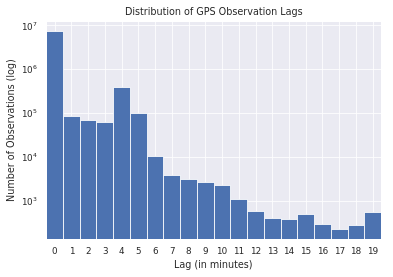

In [12]:
import numpy as np

def bin_labels(bins, **kwargs):
    binw = (max(bins) - min(bins)) / (len(bins)-1)
    plt.xticks(np.arange(min(bins)+binw/2, max(bins), binw), bins, **kwargs)
    plt.xlim(bins[0], bins[-1])
    
with psycopg2.connect(user=db_user, host=db_host, port=db_host_port, database='interact_db') as conn:
    sql = """
        SELECT lag_minutes 
        FROM (
            SELECT user_id, 
                   record_time, 
                   (extract ('epoch' from (record_time - LAG(record_time)
                        OVER (
                            PARTITION BY (user_id)
                            ORDER BY (record_time)
                            )))/60.0)
                        as lag_minutes
            FROM level_0.tmpuniqgpsobs
            ) as lagcalc
        WHERE lag_minutes > 0 AND lag_minutes < 20
        """
    cur = conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor)
    cur.execute(sql)
    rows = cur.fetchall()
    data = [float(x['lag_minutes']) for x in rows]
    bins=list(range(0,21))
    print(f"Binning {len(rows)} GPS lag values")

    plt.hist(data, bins=bins)
    bin_labels(bins)
    plt.yscale('log')
    plt.xlabel('Lag (in minutes)')
    plt.ylabel('Number of Observations (log)')
    plt.title('Distribution of GPS Observation Lags')

In [ ]:
# THIS CELL KEEPS CRASHING BEFORE COMPLETE - PROBABLY MEMORY CONSTRAINED
# And again for XL
with psycopg2.connect(user=db_user, host=db_host, port=db_host_port, database='interact_db') as conn:
    sql = """
        SELECT lag_minutes 
        FROM (
            SELECT user_id, 
                   record_time, 
                   (extract ('epoch' from (record_time - LAG(record_time)
                        OVER (
                            PARTITION BY (user_id)
                            ORDER BY (record_time)
                            )))/60.0)
                        as lag_minutes
            FROM level_0.tmpuniqaccelobs
            ) as lagcalc
        WHERE lag_minutes > 0 AND lag_minutes < 20
        """
    cur = conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor)
    cur.execute(sql)
    rows = cur.fetchall()
    data = [float(x['lag_minutes']) for x in rows]
    bins=list(range(0,21))
    print(f"Binning {len(rows)} XL lag values")

    plt.hist(data, bins=bins)
    bin_labels(bins)
    plt.yscale('log')
    plt.xlabel('Lag (in minutes)')
    plt.ylabel('Number of Observations (log)')
    plt.title('Distribution of XL Observation Lags')

#### Did some users gather data for extended periods?

In [20]:
with psycopg2.connect(user=db_user, host=db_host, port=db_host_port, database='interact_db') as conn:
    cur = conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor)
    sql = """
        SELECT min(dur) min_days, max(dur) max_days, avg(dur) avg_days
        FROM (
            SELECT num_obs, first, last, extract(days from last-first) as dur 
            FROM (
                SELECT count(1) as num_obs, min(record_time) as first, max(record_time) as last 
                FROM level_0.tmpuniqgpsobs 
                GROUP BY user_id
             ) count_recs
        ) summarize_counts
        """
    cur.execute(sql)
    row = cur.fetchone()
    data = [[x,row[x]] for x in row.keys()]
    print("Figure: GPS Sampling Periods")
    print(tabulate(data,stralign='right'))

Figure: GPS Sampling Periods
--------  -------
min_days   0
max_days  49
avg_days  25.6159
--------  -------


In [21]:
with psycopg2.connect(user=db_user, host=db_host, port=db_host_port, database='interact_db') as conn:
    cur = conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor)
    sql = """
        SELECT min(dur) min_days, max(dur) max_days, avg(dur) avg_days
        FROM (
            SELECT num_obs, first, last, extract(days from last-first) as dur 
            FROM (
                SELECT count(1) as num_obs, min(record_time) as first, max(record_time) as last 
                FROM level_0.tmpuniqaccelobs 
                GROUP BY user_id
             ) count_recs
        ) summarize_counts
        """
    cur.execute(sql)
    row = cur.fetchone()
    data = [[x,row[x]] for x in row.keys()]
    print("Figure: XL Sampling Periods")
    print(tabulate(data,stralign='right'))

Figure: XL Sampling Periods
--------  -------
min_days   0
max_days  49
avg_days  25.7895
--------  -------


Since the average collection window for each user is well within the 28-day maximum, extra-wide collection periods do not account for the extra data.

#### Did some users contribute unusual numbers of observations?

In [31]:
# Let's compare the average number of observations per user to the expected number
study_length_days = 28
duty_cycles_per_hour = 12
sample_freq = 20
samples_per_cycle = 60 * sample_freq
expected_obs_per_user = study_length_days * 24 * duty_cycles_per_hour * samples_per_cycle

with psycopg2.connect(user=db_user, host=db_host, port=db_host_port, database='interact_db') as conn:
    cur = conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor)
    sql = """
        SELECT min(num_obs) as fewest_obs, max(num_obs) as most_obs, avg(num_obs) as avg_obs
        FROM (
            SELECT count(1) num_obs 
            FROM level_0.tmpuniqaccelobs
            GROUP BY user_id
        ) count_obs
        """
    cur.execute(sql)
    row = cur.fetchone()
    data = [['expected_obs_per_user', f"{expected_obs_per_user:,}"],
            ['fewest_obs_per_user', f"{row['fewest_obs']:,}"],
            ['most_obs_per_user', f"{row['most_obs']:,}"],
            ['avg_obs_per_user', f"{row['avg_obs']:,.1f}"],
           ]
    print("Figure: Summary XL Observations Per User")
    print(tabulate(data,stralign='right'))

Figure: Summary XL Observations Per User
---------------------  -----------
expected_obs_per_user    9,676,800
  fewest_obs_per_user          968
    most_obs_per_user   24,909,419
     avg_obs_per_user  5,782,601.2
---------------------  -----------


Once again, the average is well within expected norms. It may be worth exploring that max case a bit further, but it doesn't account for having 5 times the expected number of records.

However, that raises another question. Perhaps it isn't a case of XL having too many records; perhaps it's a case of GPS having too few.

In [32]:
# Let's compare the average number of observations per user to the expected number for GPS
study_length_days = 28
duty_cycles_per_hour = 12
sample_freq = 1
samples_per_cycle = 60 * sample_freq
expected_obs_per_user = study_length_days * 24 * duty_cycles_per_hour * samples_per_cycle

with psycopg2.connect(user=db_user, host=db_host, port=db_host_port, database='interact_db') as conn:
    cur = conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor)
    sql = """
        SELECT min(num_obs) as fewest_obs, max(num_obs) as most_obs, avg(num_obs) as avg_obs
        FROM (
            SELECT count(1) num_obs 
            FROM level_0.tmpuniqgpsobs
            GROUP BY user_id
        ) count_obs
        """
    cur.execute(sql)
    row = cur.fetchone()
    data = [['expected_obs_per_user', f"{expected_obs_per_user:,}"],
            ['fewest_obs_per_user', f"{row['fewest_obs']:,}"],
            ['most_obs_per_user', f"{row['most_obs']:,}"],
            ['avg_obs_per_user', f"{row['avg_obs']:,.1f}"],
           ]
    print("Figure: Summary GPS Observations Per User")
    print(tabulate(data,stralign='right'))

Figure: Summary GPS Observations Per User
---------------------  ---------
expected_obs_per_user    483,840
  fewest_obs_per_user          7
    most_obs_per_user  1,018,278
     avg_obs_per_user   53,849.5
---------------------  ---------


And here we finally have an answer. The number of GPS observations are only about 20% of the theoretical max. This *might* be explained by poor satellite visibility, but it was my understanding that in such situations, low-accuracy samples were still being collected. It will be up to the TDT team to determine whether this is in fact a problem.

Weird. I fully expected to find no actual duty cycles here, but there they are - 4-minute lags, just as expected. The GPS reports mostly 5-minute lags instead of 4, but I'm not sure why. It's probably worth drawing the histogram to see what's going on.

EXCEPT THIS HISTOGRAM WANTS TO RUN FOR MORE THAN A DAY, SO PROBABLY NOT WORTH IT

## DC Correlations

Since the GPS and XL tables do not appear to be synchronized at the observation level, we should now assess whether they are at least synchronized at the DC level.

### Unfiltered Duty Cycles
We'll start by looking at the sync between the DCs found in the unfiltered observations. (Recall, this means that the duplicates have all been reduced to unique timestamps, but have not been removed.)

In [ ]:
print("Figure: Comparison of DC Observation Matches:")
table = [["Num GPS DCs",f"{17:,}"], 
         ["Num Accel DCs",f"{19:,}"], 
         ["Exact Obsv Matches",num_dc_matches], 
         ["Match Rate",f"{100*float(num_dc_matches)/float(17):0.1f}%"]]


print(tabulate(table,stralign='right'))

In [12]:
from tabulate import tabulate
# Count the left join matches for DCs between GPS and Accel tables
with psycopg2.connect(user=db_user, host=db_host, port=db_host_port, database='interact_db') as conn:
    cur = conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor)
    sql = """
        SELECT  sum(count) as num_matched_dcs, 
                count(1) as num_matched_users, 
                avg(count) as avg_matched_dcs_per_user,
                percentile_disc(0.10) within group (order by count asc) as match_percentile_10,
                percentile_disc(0.25) within group (order by count asc) as match_percentile_25,
                percentile_disc(0.5) within group (order by count asc) as match_percentile_50,
                percentile_disc(0.75) within group (order by count asc) as match_percentile_75,
                percentile_disc(0.90) within group (order by count asc) as match_percentile_90
        FROM (
            SELECT count(1) as count, min(gps.user_id) as user_id, min(gps.dc) as dc
            FROM level_0.tmpgpsdcs as gps
            INNER JOIN level_0.tmpacceldcs as accel
                ON gps.dc = accel.dc 
                AND gps.user_id = accel.user_id
            GROUP BY gps.user_id
            ) find_matches
            """
    cur.execute(sql)
    row = cur.fetchone()
    data = [['num_gps_dcs', num_gps_dcs],
            ['avg_gps_dcs_per_user', avg_gps_dcs_per_user],]
    data.extend([[x,row[x]] for x in row.keys()])
    print("Figure: Count of Synchronized DCs in GPS vs XL")
    print(tabulate(data,stralign='right'))

Figure: Count of Synchronized DCs in GPS vs XL
------------------------  ---------
             num_gps_dcs  663625
    avg_gps_dcs_per_user    4394.87
         num_matched_dcs  659119
       num_matched_users     151
avg_matched_dcs_per_user    4365.03
     match_percentile_10     247
     match_percentile_25    1879
     match_percentile_50    5026
     match_percentile_75    6642
     match_percentile_90    7679
------------------------  ---------


This all seems reasonable, but it does not take into account the viability of the DCs involved, so we'll look at that next.

In [13]:
# Count the left join matches for VIABLE DCs between GPS and Accel tables
with psycopg2.connect(user=db_user, host=db_host, port=db_host_port, database='interact_db') as conn:
    cur = conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor)
    sql = """
        SELECT  sum(count) as num_matched_dcs, 
                count(1) as num_matched_users, 
                avg(count) as avg_matched_dcs_per_user,
                percentile_disc(0.10) within group (order by count asc) as match_percentile_10,
                percentile_disc(0.25) within group (order by count asc) as match_percentile_25,
                percentile_disc(0.5) within group (order by count asc) as match_percentile_50,
                percentile_disc(0.75) within group (order by count asc) as match_percentile_75,
                percentile_disc(0.90) within group (order by count asc) as match_percentile_90
        FROM (
            SELECT count(1) as count, min(gps.user_id) as user_id, min(gps.dc) as dc
            FROM level_0.tmpgpsdcs as gps
            INNER JOIN level_0.tmpacceldcs as accel
                ON gps.dc = accel.dc 
                AND gps.user_id = accel.user_id
            WHERE gps.recs_per_dc >= 10    -- make sure GPS DC is viable
            AND   accel.recs_per_dc >= 120 -- make sure XL DC is viable
            GROUP BY gps.user_id
            ) find_matches
            """
    cur.execute(sql)
    row = cur.fetchone()
    data = [[x,row[x]] for x in row.keys()]
    print("Figure: Count of Synchronized Viable DCs in GPS vs XL")
    print(tabulate(data,stralign='right'))


Figure: Count of Synchronized Viable DCs in GPS vs XL
------------------------  ---------
         num_matched_dcs  80428
       num_matched_users    145
avg_matched_dcs_per_user    554.676
     match_percentile_10      9
     match_percentile_25     40
     match_percentile_50    125
     match_percentile_75    811
     match_percentile_90   1415
------------------------  ---------


This may be a concern. When we limit DCs to those with viable observation counts, the number of synchronized pairs drops from 4300 per user to less than 600.

I'm not sure if the analysis permits "hybrid" pairs (where one of DC or XL is viable, but the other is not), but in case that's an option, we'll count those as well.

In [16]:
# Out of curiosity, count the left join matches where at least one of the DCs is viable
with psycopg2.connect(user=db_user, host=db_host, port=db_host_port, database='interact_db') as conn:
    cur = conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor)
    sql = """
        SELECT  sum(count) as num_matched_dcs, 
                count(1) as num_matched_users, 
                avg(count) as avg_matched_dcs_per_user,
                percentile_disc(0.10) within group (order by count asc) as match_percentile_10,
                percentile_disc(0.25) within group (order by count asc) as match_percentile_25,
                percentile_disc(0.5) within group (order by count asc) as match_percentile_50,
                percentile_disc(0.75) within group (order by count asc) as match_percentile_75,
                percentile_disc(0.90) within group (order by count asc) as match_percentile_90
        FROM (
            SELECT count(1) as count, min(gps.user_id) as user_id, min(gps.dc) as dc
            FROM level_0.tmpgpsdcs as gps
            INNER JOIN level_0.tmpacceldcs as accel
                ON gps.dc = accel.dc 
                AND gps.user_id = accel.user_id
            WHERE gps.recs_per_dc >= 10    -- make sure GPS DC is viable
            OR   accel.recs_per_dc >= 120 -- make sure XL DC is viable
            GROUP BY gps.user_id
            ) find_matches
            """
    cur.execute(sql)
    row = cur.fetchone()
    data = [['num_accel_dcs', num_accel_dcs],
            ['avg_accel_dcs_per_user', avg_accel_dcs_per_user],]

    data.extend([[x,row[x]] for x in row.keys()])
    print("Figure: Count of Synchronized Semi-Viable DCs in GPS vs XL")
    print(tabulate(data,stralign='right'))


Figure: Count of Synchronized Semi-Viable DCs in GPS vs XL
------------------------  ---------
           num_accel_dcs  715499
  avg_accel_dcs_per_user    4707.23
         num_matched_dcs  657930
       num_matched_users     151
avg_matched_dcs_per_user    4357.15
     match_percentile_10     236
     match_percentile_25    1878
     match_percentile_50    5015
     match_percentile_75    6609
     match_percentile_90    7675
------------------------  ---------


So if researchers need both DCs to be viable in each matched pair, they will have little data to work with, but if the analysis can be done with hybrid pairs, it looks like they'll have virtually the entire DC set to work with.

# TL;DR

Count the viable DCs:
- There are only 20% of the expected number of GPS observations in the table. Instead of the appx 480K samples a fully observed user would have, we have captured only about 53K unique timestamps for each
- Of the approx 8,000 DCs we theoretically observed per user, we have data in a little more than half of them, in both the GPS and XL tables
- If we consider only viable DCs (>= 120 observations for XL, >= 10 for GPS)
  - We lose about 1% of the XL DCs
  - But we drop 88% of the GPS DCs, falling to only 560 viable DCs per user
  - That number falls to 545 if we filter out conflicted observations
  - And it falls to 541 if we filter out ALL duplicate records
  
When we examine synchronization between GPS and XL observation timestamps (left joins):
- Only 4.3% of GPS observations have matching XL observations prior to filtering
- And it drops to 3.8% when either type of duplication filtering is applied

Finally, I looked at synchronization at the DC level as well.
- In the unfiltered data, virtually all GPS DCs have corresponding XL DCs
- When we try to match viable DCs, an average user has only 550 GPS DCs with matching XL DCs (the median is 125)
- Curiously, if we require only one of the DCs in each pair to be viable, we lose almost none of them
- From this I conclude that it is relatively uncommon for both GPS and XL to be viable at the same time 
